In [1]:
# import sys 
# sys.path.append('../')
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from rich import print as pprint


/home/mahdigilany/offline_codes/codes/TRUSnet


## Loading all configs

In [2]:
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra
from src.configuration import register_configs
from tqdm import tqdm

register_configs()

GlobalHydra.instance().clear()
initialize(config_path="../configs", version_base="1.1")

configs = compose(
    config_name="experiment/01_SNGP_baseline_MG_2023-03-14.yaml",
    )
# lightning_data_module = instantiate(dm_config)['datamodule']
# print(lightning_data_module)
# lightning_data_module.setup()

pprint(OmegaConf.to_yaml(configs))
# 

name: sngp_resnet10_uva600_ndl&prst_nospectral_batchnorm
seed: 0
split_seed: 0
batch_size: 32
num_epochs: 30
num_classes: 2
loss_name: crossentropy_loss
freeze_backbone: false
data:
  dataset_name: exact_patches_sl_uva600_centers_balanced_ndl_prst_instanceNorm
  num_workers: 4
model:
  model_name: sngp_resnet10
  num_deep_features: 512
  num_gp_features: 128
  mean_field_factor: 25
  spectral_norm: true
  spectral_config:
    input_size: 256
    coefficient: 1.0
    n_power_iterations: 1
optimizer:
  lr: 0.0001
  weight_decay: 1.0e-06
logger:
  wandb:
    entity: mahdigilany
    project: IJCARS
    id: 0

In [3]:
from pytorch_lightning import seed_everything

seed_everything(configs.seed)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


0

## Loading data

In [9]:
import torch
from src.data.registry import create_dataset

configs.data.num_workers = 0

train_ds = create_dataset(configs.data.dataset_name, split="train")
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=configs.batch_size, shuffle=True, num_workers=configs.data.num_workers
)
val_ds = create_dataset(configs.data.dataset_name, split="val")
val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=configs.batch_size, shuffle=False, num_workers=configs.data.num_workers
)
test_ds = create_dataset(configs.data.dataset_name, split="test")
test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=configs.batch_size, shuffle=False, num_workers=configs.data.num_workers
)

Indexing Patches: 100%|██████████| 81/81 [00:00<00:00, 18030.92it/s]


In [20]:
# train_ds.cores[0].download_and_preprocess_iq()

## Loading model

In [5]:
from src.modeling.registry import create_model
from src.modeling.GP_approx_models import Laplace
configs.model.model_name = "spectral_resnet10_feature_extractor"
spectral_feature_extractor = create_model(configs.model.model_name,)# spectral_norm=False)
model = Laplace(spectral_feature_extractor,
                num_deep_features=configs.model.num_deep_features,
                num_gp_features=configs.model.num_gp_features,
                mean_field_factor=configs.model.mean_field_factor,
                num_data= len(train_ds),
)
# model = nn.Sequential(spectral_feature_extractor, nn.Linear(512,2))

In [7]:
"""If the model is using registered model in src/modeling/registry/registry.py"""
from src.modeling.registry import create_model
model = create_model(**configs.model, num_data= len(train_ds))


In [6]:
# spectral_feature_extractor.__dict__
# model.__dict__

## Defining optimizer

In [8]:
from src.modeling.loss.loss_functions import create_loss_fx
from src.modeling.optimizer_factory import configure_optimizers

# optimizer = configure_optimizers(configs.optimizer, model)
optimizer = torch.optim.Adam(model.parameters(), lr=configs.optimizer.lr, weight_decay=configs.optimizer.weight_decay)
criterion = create_loss_fx(configs.loss_name, num_classes=configs.num_classes)

In [9]:
# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer, milestones=milestones, gamma=0.2
# )

In [9]:
"""Use script sngp_training to train the model instead of this cell."""

# from torchmetrics import Accuracy


# model.to("cuda")
# configs.num_epochs = 20

# epochs_Loss = []
# for epoch in range(configs.num_epochs):
#     print(f"Epoch {epoch}")
#     model.train()
#     # acc = Accuracy(average="macro", num_classes=2).to("cuda")
    
#     # reset the precision matrix based on SNGP paper
#     model.reset_precision_matrix()
#     batches_Loss = []
#     for batch in tqdm(train_dl, desc="Training"):
#         x, y, metadata = batch
#         x = x.to("cuda")
#         y = y.to("cuda")
#         y_hat = model(x)
#         loss = criterion(y_hat, y, reduction='mean')
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         batches_Loss.append(loss.item())
#         # acc(y_hat, y)
#     epochs_Loss.append(np.mean(batches_Loss))


    

In [10]:
# torch.save(model.state_dict(), "SNGP_model_20epochs.pt")
# 

In [11]:
# model(x)[1].shape   

## Loading checkpoint

In [7]:
# state_dict = torch.load("logs/ckpt_store/sngp_uva_ndl_meanfield_25_weightes_sampler.pt")
state_dict = torch.load("logs/ckpt_store/sngp_resnet10_uva600_ndl&prst_no_batchnorm.pt")
# state_dict = torch.load("logs/ckpt_store/resnet10_uva600_ndl&prst.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
"""In order to load to the model in the registry"""
state_dict = torch.load("logs/ckpt_store/sngp_resnet10_extra_lin_uva600_ndl&prst_no_batchnorm_pretrained_with_prostate_frozen_backbone.pt")
model.load_state_dict(state_dict)

In [9]:
# get columns of data frame
# train_metadata = train_ds.metadata
# train_metadata.columns
# list(set(train_metadata['center']))
# list(train_metadata.query('center == "UVA"').index)

['UVA']

In [10]:
from torchmetrics import Accuracy, AUROC
from src.lightning.callbacks.components import metrics

# validation
val_metadata = val_ds.metadata
# patch metric manager just collects the predictions and labels and finds all metrics 
# TODO: patch metric manager needs major update
patch_metric_manager = metrics.PatchMetricManager(list(set(val_metadata['center'])), device="cpu")

# acc = Accuracy(average="macro", num_classes=2).to("cuda")
# auc = AUROC(average="macro", num_classes=2).to("cuda")
model.seen_data = torch.tensor(len(train_ds))
batches_Loss = []
model.to("cuda")
model.eval()
with torch.no_grad():
    for batch in tqdm(val_dl, desc="Validation"):
        x, y, metadata = batch
        x = x.to("cuda")
        y = y.to("cuda")
        y_hat = model(x)
        # y_hat = y_hat[0]
        loss = criterion(y_hat, y, reduction='mean')
        batches_Loss.append(loss.item())
        patch_metric_manager.update_wMetadata(ds_type="val", logits=y_hat, labels=y, metadata=metadata)

print(f"Validation Loss: {np.mean(batches_Loss)}")

Validation: 100%|██████████| 94/94 [00:21<00:00,  4.31it/s]

Validation Loss: 0.7899583819064688


In [11]:
patch_metric_manager.center_metric_dict['ALL'].gs_valMetric_dict["ALL"].compute()
patch_metric_manager.compute('val', 'ALL')

{'val/finetune_auc': tensor(0.6459, device='cuda:0'),
 'val/finetune_ap': tensor(0.6225, device='cuda:0'),
 'val/finetune_acc_macro': tensor(0.6031, device='cuda:0'),
 'val/finetune_sen': tensor(0.6031, device='cuda:0'),
 'val/finetune_spe': tensor(0.6031, device='cuda:0'),
 'val/finetune_f1': tensor(0.6055, device='cuda:0')}

In [12]:
# test
# acc = Accuracy(average="macro", num_classes=2).to("cuda")
# auc = AUROC(average="macro", num_classes=2).to("cuda")
batches_Loss = []
model.to("cuda")
model.eval()
with torch.no_grad():
    for batch in tqdm(test_dl, desc="Test"):
        x, y, metadata = batch
        x = x.to("cuda")
        y = y.to("cuda")
        y_hat = model(x)
        # y_hat = y_hat[0]
        loss = criterion(y_hat, y, reduction='mean')
        batches_Loss.append(loss.item())
        patch_metric_manager.update_wMetadata(ds_type="test", logits=y_hat, labels=y, metadata=metadata)
        
print(f"Test Loss: {np.mean(batches_Loss)}")

Test: 100%|██████████| 108/108 [00:25<00:00,  4.31it/s]

Test Loss: 0.6870539896190166


In [13]:
patch_metric_manager.center_metric_dict['ALL'].gs_testMetric_dict["ALL"].compute()
patch_metric_manager.compute('test', 'ALL')

{'test/finetune_auc': tensor(0.7114, device='cuda:0'),
 'test/finetune_ap': tensor(0.6984, device='cuda:0'),
 'test/finetune_acc_macro': tensor(0.6453, device='cuda:0'),
 'test/finetune_sen': tensor(0.6453, device='cuda:0'),
 'test/finetune_spe': tensor(0.6453, device='cuda:0'),
 'test/finetune_f1': tensor(0.6499, device='cuda:0')}

In [27]:
"""A better way to calculate core metrics is used in sngp_training.py."""
core_metric_manager = metrics.CoreMetricManager(val_ds, test_ds, list(set(val_metadata['center'])), device="cpu")

val_logits, val_labels, val_gs = core_metric_manager.get_logits_labels_grades_from_patchManager("val", patch_metric_manager)
core_metric_manager.update("val", val_logits, val_labels, val_gs)

test_logits, test_labels, test_gs = core_metric_manager.get_logits_labels_grades_from_patchManager("test", patch_metric_manager)
core_metric_manager.update("test", test_logits, test_labels, test_gs)

pprint(core_metric_manager.compute("test", "ALL"))
pprint(core_metric_manager.compute("val", "ALL"))

{
    'test/finetune_core_auc': tensor(0.9245),
    'test/finetune_core_ap': tensor(0.9186),
    'test/finetune_core_acc_macro': tensor(0.6997),
    'test/finetune_core_sen': tensor(0.6997),
    'test/finetune_core_spe': tensor(0.6997),
    'test/finetune_core_f1': tensor(0.7077)
}

{
    'val/finetune_core_auc': tensor(0.7385),
    'val/finetune_core_ap': tensor(0.7257),
    'val/finetune_core_acc_macro': tensor(0.7039),
    'val/finetune_core_sen': tensor(0.7039),
    'val/finetune_core_spe': tensor(0.7039),
    'val/finetune_core_f1': tensor(0.7161)
}

#### plotting val logits vs val involvement repeated for each patch

In [19]:
# # val_logits['UVA'].softmax(dim=1)
# # val_labels['UVA'].shape
# val_metadata = val_ds.metadata
# val_metadata['pct_cancer'].replace(np.NaN, 0, inplace=True)
# val_pct_repeated = np.repeat(val_metadata['pct_cancer'], 55)
# plt.scatter(val_pct_repeated, val_logits['UVA'].softmax(dim=1)[:,1].cpu().numpy(), alpha=0.1, s=10)
# # val_metadata['pct_cancer']

In [20]:
# test_metadata = test_ds.metadata
# test_metadata['pct_cancer'].replace(np.NaN, 0, inplace=True)
# test_pct_repeated = np.repeat(test_metadata['pct_cancer'], 55)
# plt.scatter(test_pct_repeated, test_logits['UVA'].softmax(dim=1)[:,1].cpu().numpy(), alpha=0.1, s=10)

### Core scatter plots

In [15]:
""""For core scatter plots we need to find the core logits and labels which is done using core metric manager"""
corelen_list = core_metric_manager.corelen_dict['val']['UVA']
val_core_logits, val_core_labels, val_core_gs =\
    core_metric_manager.aggregate_patches(val_logits['UVA'], val_labels['UVA'], val_gs['UVA'], corelen_list) 
    
corelen_list = core_metric_manager.corelen_dict['test']['UVA']
test_core_logits, test_core_labels, test_core_gs =\
    core_metric_manager.aggregate_patches(test_logits['UVA'], test_labels['UVA'], test_gs['UVA'], corelen_list) 

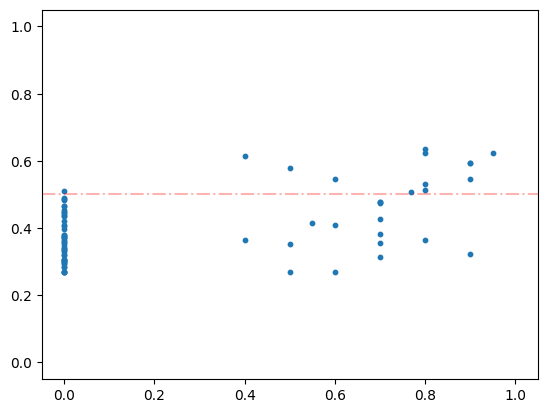

In [16]:
val_metadata = val_ds.metadata
val_metadata['pct_cancer'].replace(np.NaN, 0, inplace=True)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axhline(y=0.5, color='r', linestyle='-.', alpha=0.3)
plt.scatter(val_metadata['pct_cancer']/100, val_core_logits.softmax(dim=1)[:,1].cpu().numpy(), alpha=1, s=10)

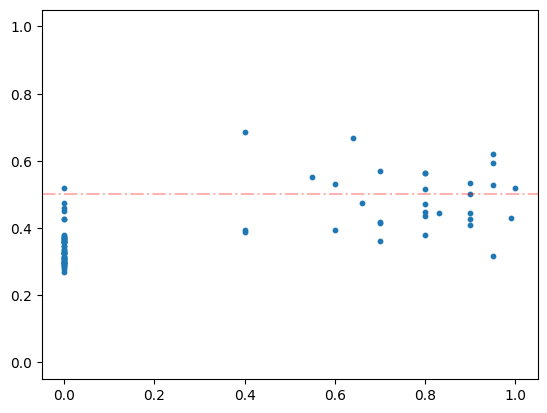

In [17]:
test_metadata = test_ds.metadata
test_metadata['pct_cancer'].replace(np.NaN, 0, inplace=True)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axhline(y=0.5, color='r', linestyle='-.', alpha=0.3)
plt.scatter(test_metadata['pct_cancer']/100, test_core_logits.softmax(dim=1)[:,1].cpu().numpy(), alpha=1, s=10)

## Calculating uncertainty

In [18]:
def calculate_uncertainty(logits):
    # Dempster-Shafer uncertainty for SNGP
    # From: https://github.com/google/uncertainty-baselines/blob/main/baselines/cifar/ood_utils.py#L22
    num_classes = logits.shape[1]
    belief_mass = logits.exp().sum(1)
    uncertainty = num_classes / (belief_mass + num_classes)
    return uncertainty

In [19]:
# getting uncertainty for val and test patch wise
val_uncertainty = calculate_uncertainty(val_logits['UVA'].detach().cpu())
test_uncertainty = calculate_uncertainty(test_logits['UVA'].detach().cpu())

## Please skip until where I define a function to get performance metrics based on a threshold

In [42]:
"""Performance on certain samples based on threshold.
Uncertain samples are removed from the prediction.
"""

threshold = 0.4
# normalize uncertainty
val_uncertainty = (val_uncertainty - val_uncertainty.min()) / (val_uncertainty.max() - val_uncertainty.min())
test_uncertainty = (test_uncertainty - test_uncertainty.min()) / (test_uncertainty.max() - test_uncertainty.min())
# plt.hist(val_uncertainty, bins=100)
# plt.show()

certain_val_data_idx = np.where(val_uncertainty < threshold)[0]
certain_test_data_idx = np.where(test_uncertainty < threshold)[0]

certain_val_logits = val_logits['UVA'][certain_val_data_idx, :]
certain_val_labels = val_labels['UVA'][certain_val_data_idx]
val_patch_metadata = val_ds.metadata.loc[val_ds.metadata.index.repeat(val_ds.core_lengths)].reset_index(drop=True)
certain_val_metadata = val_patch_metadata.loc[certain_val_data_idx].reset_index(drop=True)


certain_test_logits = test_logits['UVA'][certain_test_data_idx, :]
certain_test_labels = test_labels['UVA'][certain_test_data_idx]
test_patch_metadata = test_ds.metadata.loc[test_ds.metadata.index.repeat(test_ds.core_lengths)].reset_index(drop=True)
certain_test_metadata = test_patch_metadata.loc[certain_test_data_idx].reset_index(drop=True)


patch_metric_manager_certain = metrics.PatchMetricManager(list(set(val_metadata['center'])), device="cpu")
patch_metric_manager_certain.update_wMetadata("val", certain_val_logits, certain_val_labels, certain_val_metadata)
patch_metric_manager_certain.update_wMetadata("test", certain_test_logits, certain_test_labels, certain_test_metadata)

patch_metric_manager_certain.compute('val', 'ALL')
patch_metric_manager_certain.compute('test', 'ALL')

# core_metric_manager_certain = metrics.CoreMetricManager(val_ds, test_ds, list(set(val_metadata['center'])), device="cpu")
# core_metric_manager.aggregate_patches(val_logits['UVA'], val_labels['UVA'], val_gs['UVA'], corelen_list)

{'test/finetune_auc': tensor(0.8800, device='cuda:0'),
 'test/finetune_ap': tensor(0.8745, device='cuda:0'),
 'test/finetune_acc_macro': tensor(0.7956, device='cuda:0'),
 'test/finetune_sen': tensor(0.7956, device='cuda:0'),
 'test/finetune_spe': tensor(0.7956, device='cuda:0'),
 'test/finetune_f1': tensor(0.7936, device='cuda:0')}

In [33]:
"""Performance on certain cores based on threshold.
Uncertain samples are removed then core performance is found only using their certain samples.
"""
core_len_cumsum = np.cumsum(val_ds.core_lengths)
val_certain_core_lengths = []
for i, val in enumerate(core_len_cumsum):
    if i==0:
        indices_list = certain_val_data_idx[certain_val_data_idx < val]
    else: 
        indices_list = certain_val_data_idx[(certain_val_data_idx < val) & (certain_val_data_idx >= core_len_cumsum[i-1])]
    val_certain_core_lengths.append(len(indices_list))
    
core_len_cumsum = np.cumsum(test_ds.core_lengths)
test_certain_core_lengths = []
for i, val in enumerate(core_len_cumsum):
    if i==0:
        indices_list = certain_test_data_idx[certain_test_data_idx < val]
    else: 
        indices_list = certain_test_data_idx[(certain_test_data_idx < val) & (certain_test_data_idx >= core_len_cumsum[i-1])]
    test_certain_core_lengths.append(len(indices_list))

import copy
certain_val_ds = copy.deepcopy(val_ds)
certain_val_ds.core_lengths = val_certain_core_lengths
certain_test_ds = copy.deepcopy(test_ds)
certain_test_ds.core_lengths = test_certain_core_lengths

core_metric_manager_certain = metrics.CoreMetricManager(certain_val_ds, certain_test_ds, list(set(val_metadata['center'])), device="cpu")
core_metric_manager_certain.update_wPatchmanager(patch_metric_manager_certain, "val")
core_metric_manager_certain.update_wPatchmanager(patch_metric_manager_certain, "test")

core_metric_manager_certain.compute('val', 'ALL')
core_metric_manager_certain.compute('test', 'ALL')

{'test/finetune_core_auc': tensor(0.9235),
 'test/finetune_core_ap': tensor(0.9176),
 'test/finetune_core_acc_macro': tensor(0.8539),
 'test/finetune_core_sen': tensor(0.8539),
 'test/finetune_core_spe': tensor(0.8539),
 'test/finetune_core_f1': tensor(0.8259)}

In [71]:
"""Performance on samples only from certain cores based on threshold.
"""

threshold = 0.6
minimum_certain_core_len_percentile = 0.6
remove_uncertain_samples_from_uncertain_cores = False
# normalize uncertainty
# val_uncertainty = (val_uncertainty - val_uncertainty.mean()) / val_uncertainty.std()
# test_uncertainty = (test_uncertainty - test_uncertainty.mean()) / test_uncertainty.std()
val_uncertainty = (val_uncertainty - val_uncertainty.min()) / (val_uncertainty.max() - val_uncertainty.min())
test_uncertainty = (test_uncertainty - test_uncertainty.min()) / (test_uncertainty.max() - test_uncertainty.min())
# plt.hist(val_uncertainty, bins=100)
# plt.show()

core_len_cumsum = np.cumsum(val_ds.core_lengths)
val_certain_core_lengths = []
val_patch_indices_for_selected_cores = []
for i, val in enumerate(core_len_cumsum):
    if i==0:
        certain_patch_indices = val_uncertainty[:val]<threshold
    else: 
        certain_patch_indices = val_uncertainty[core_len_cumsum[i-1]:val]<threshold    
    
    new_core_len = (certain_patch_indices).sum()
    if remove_uncertain_samples_from_uncertain_cores:
        # not removing uncertain samples from uncertain cores
        new_core_len = val_ds.core_lengths[i] if new_core_len > val_ds.core_lengths[i] * minimum_certain_core_len_percentile else 0
        val_certain_core_lengths.append(new_core_len)
        val_patch_indices_for_selected_cores.append(
            torch.ones_like(certain_patch_indices) 
            if new_core_len > 0 
            else torch.zeros_like(certain_patch_indices)
            )
    else:
        # removing uncertain samples from uncertain cores
        new_core_len = new_core_len if new_core_len > val_ds.core_lengths[i] * minimum_certain_core_len_percentile else 0
        val_certain_core_lengths.append(new_core_len)
        val_patch_indices_for_selected_cores.append(
            certain_patch_indices
            if new_core_len > 0 
            else torch.zeros_like(certain_patch_indices)
            )
    
val_patch_indices_for_selected_cores = torch.cat(val_patch_indices_for_selected_cores).numpy()


core_len_cumsum = np.cumsum(test_ds.core_lengths)
test_certain_core_lengths = []
test_patch_indices_for_selected_cores = []
for i, val in enumerate(core_len_cumsum):
    if i==0:
        certain_patch_indices = test_uncertainty[:val]<threshold
    else: 
        certain_patch_indices = test_uncertainty[core_len_cumsum[i-1]:val]<threshold    
    
    new_core_len = (certain_patch_indices).sum()
    if remove_uncertain_samples_from_uncertain_cores:
        # not removing uncertain samples from uncertain cores
        new_core_len = test_ds.core_lengths[i] if new_core_len > test_ds.core_lengths[i] * minimum_certain_core_len_percentile else 0
        test_certain_core_lengths.append(new_core_len)
        test_patch_indices_for_selected_cores.append(
            torch.ones_like(certain_patch_indices) 
            if new_core_len > 0 
            else torch.zeros_like(certain_patch_indices)
            )
    else:
        # removing uncertain samples from uncertain cores
        new_core_len = new_core_len if new_core_len > test_ds.core_lengths[i] * minimum_certain_core_len_percentile else 0
        test_certain_core_lengths.append(new_core_len)
        test_patch_indices_for_selected_cores.append(
            certain_patch_indices 
            if new_core_len > 0 
            else torch.zeros_like(certain_patch_indices)
            )  
              
test_patch_indices_for_selected_cores = torch.cat(test_patch_indices_for_selected_cores).numpy()


certain_val_logits = val_logits['UVA'][val_patch_indices_for_selected_cores, :]
certain_val_labels = val_labels['UVA'][val_patch_indices_for_selected_cores]
val_patch_metadata = val_ds.metadata.loc[val_ds.metadata.index.repeat(val_ds.core_lengths)].reset_index(drop=True)
certain_val_metadata = val_patch_metadata.loc[val_patch_indices_for_selected_cores].reset_index(drop=True)

certain_test_logits = test_logits['UVA'][test_patch_indices_for_selected_cores, :]
certain_test_labels = test_labels['UVA'][test_patch_indices_for_selected_cores]
test_patch_metadata = test_ds.metadata.loc[test_ds.metadata.index.repeat(test_ds.core_lengths)].reset_index(drop=True)
certain_test_metadata = test_patch_metadata.loc[test_patch_indices_for_selected_cores].reset_index(drop=True)


patch_metric_manager_certain = metrics.PatchMetricManager(list(set(val_metadata['center'])), device="cpu")
patch_metric_manager_certain.update_wMetadata("val", certain_val_logits, certain_val_labels, certain_val_metadata)
patch_metric_manager_certain.update_wMetadata("test", certain_test_logits, certain_test_labels, certain_test_metadata)

patch_metric_manager_certain.compute('val', 'ALL')
patch_metric_manager_certain.compute('test', 'ALL')

{'test/finetune_auc': tensor(0.7662, device='cuda:0'),
 'test/finetune_ap': tensor(0.7611, device='cuda:0'),
 'test/finetune_acc_macro': tensor(0.7060, device='cuda:0'),
 'test/finetune_sen': tensor(0.7060, device='cuda:0'),
 'test/finetune_spe': tensor(0.7060, device='cuda:0'),
 'test/finetune_f1': tensor(0.6858, device='cuda:0')}

In [72]:
"""Performance on certain cores based on threshold.
Cores with x percent of uncertain samples are removed.
"""
import copy
certain_val_ds = copy.deepcopy(val_ds)
certain_val_ds.core_lengths = val_certain_core_lengths
certain_test_ds = copy.deepcopy(test_ds)
certain_test_ds.core_lengths = test_certain_core_lengths

core_metric_manager_certain = metrics.CoreMetricManager(certain_val_ds, certain_test_ds, list(set(val_metadata['center'])), device="cpu")
core_metric_manager_certain.update_wPatchmanager(patch_metric_manager_certain, "val")
core_metric_manager_certain.update_wPatchmanager(patch_metric_manager_certain, "test")

core_metric_manager_certain.compute('val', 'ALL')
core_metric_manager_certain.compute('test', 'ALL')



{'test/finetune_core_auc': tensor(0.8497),
 'test/finetune_core_ap': tensor(0.7311),
 'test/finetune_core_acc_macro': tensor(0.8394),
 'test/finetune_core_sen': tensor(0.8394),
 'test/finetune_core_spe': tensor(0.8394),
 'test/finetune_core_f1': tensor(0.8330)}

In [30]:
# # this code should be used for logging with wandb
# # writer should change to wandb.log
# import wandb
# wandb.init(project=configs.logger.wandb.project, entity=configs.logger.wandb.entity)


# for name, layer in model.feature_extractor.named_modules():
#     if isinstance(layer, torch.nn.Conv2d):        
#         wandb.log({f"mu/{name}": layer.weight_mu})
#         wandb.log({f"sigma/{name}": layer.weight_sigma})

/tmp/ipykernel_1230668/4251157400.py:9: RuntimeWarning: invalid value encountered in divide
  ax2.bar(np.arange(20)*5, certain_hist/all_hist, alpha=0.5, color='b')


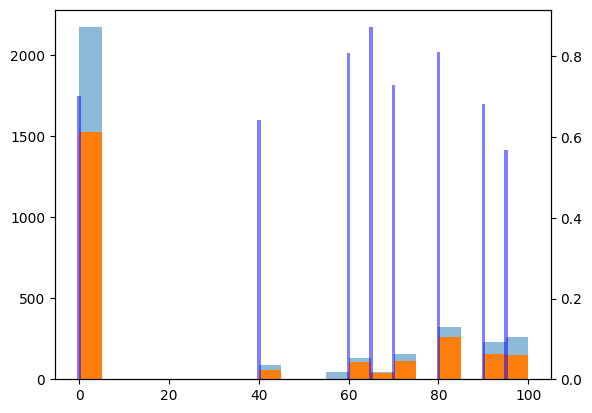

In [91]:
# plt.hist(certain_val_metadata['pct_cancer'], bins=20)
all_hist, _ = np.histogram(test_patch_metadata['pct_cancer'], bins=20, )
certain_hist, _= np.histogram(certain_test_metadata['pct_cancer'], bins=20, )

fig,ax = plt.subplots()
ax.hist(test_patch_metadata['pct_cancer'], bins=20, alpha=0.5)
ax.hist(certain_test_metadata['pct_cancer'], bins=20)
ax2=ax.twinx()
ax2.bar(np.arange(20)*5, certain_hist/all_hist, alpha=0.5, color='b')
plt.show()
# certain_val_metadata.query('grade != "Benign"')

## Calculating performance metrics based on threshold

In [21]:
def performance_on_certain_patches_based_on_threshold(threshold, patch_uncertainty, patch_logits, patch_labels, dataset):
    """Performance on certain samples based on threshold.
    Uncertain samples are removed from the prediction.
    """
    # normalize uncertainty
    patch_uncertainty = (patch_uncertainty - patch_uncertainty.min()) / (patch_uncertainty.max() - patch_uncertainty.min())

    certain_data_idx = np.where(patch_uncertainty < threshold)[0]

    certain_logits = patch_logits[certain_data_idx, :]
    certain_labels = patch_labels[certain_data_idx]
    patch_metadata = dataset.metadata.loc[dataset.metadata.index.repeat(dataset.core_lengths)].reset_index(drop=True)
    certain_metadata = patch_metadata.loc[certain_data_idx].reset_index(drop=True)


    patch_metric_manager_certain = metrics.PatchMetricManager(list(set(dataset.metadata['center'])), device="cpu")
    patch_metric_manager_certain.update_wMetadata("val", certain_logits, certain_labels, certain_metadata)
    
    
    core_len_cumsum = np.cumsum(dataset.core_lengths)
    certain_core_lengths = []
    for i, val in enumerate(core_len_cumsum):
        if i==0:
            indices_list = certain_data_idx[certain_data_idx < val]
        else: 
            indices_list = certain_data_idx[(certain_data_idx < val) & (certain_data_idx >= core_len_cumsum[i-1])]
        certain_core_lengths.append(len(indices_list))

    import copy
    certain_ds = copy.deepcopy(dataset)
    certain_ds.core_lengths = certain_core_lengths

    core_metric_manager_certain = metrics.CoreMetricManager(certain_ds, certain_ds, list(set(dataset.metadata['center'])), device="cpu")
    core_metric_manager_certain.update_wPatchmanager(patch_metric_manager_certain, "val")

    patch_dict_performance, core_dict_performance = patch_metric_manager_certain.compute('val', 'ALL'), core_metric_manager_certain.compute('val', 'ALL')

    return patch_dict_performance, core_dict_performance

### getting performance for 10 different thresholds

In [24]:
_ds = val_ds
_logits = val_logits['UVA'].detach().cpu()
_labels = val_labels['UVA'].detach().cpu()
_uncertainty = calculate_uncertainty(_logits)

# _ds = test_ds
# _logits = test_logits['UVA'].detach().cpu()
# _labels = test_labels['UVA'].detach().cpu()
# _uncertainty = calculate_uncertainty(_logits)

patch_auc_list_thresholds = []
core_auc_list_thresholds = []
for i in range(10):
    threshold = 1 - i/10
    # print(f"threshold: {threshold}")
    patch_dict_performance, core_dict_performance =\
    performance_on_certain_patches_based_on_threshold(
        threshold,
        _uncertainty,
        _logits,
        _labels,
        _ds
        )
    [patch_auc_list_thresholds.append(v) for k,v in patch_dict_performance.items() if 'auc' in k]
    [core_auc_list_thresholds.append(v) for k,v in core_dict_performance.items() if 'auc' in k]

(0.5, 1.05)

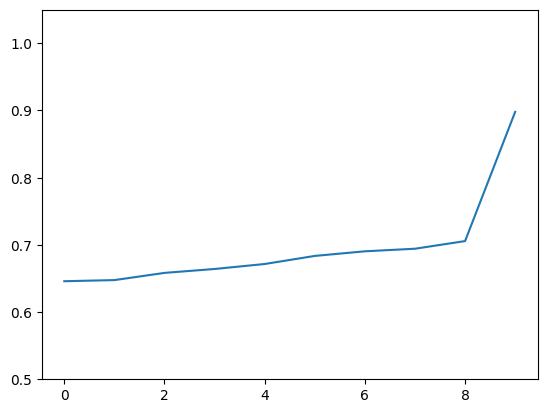

In [25]:
plt.plot(range(len(patch_auc_list_thresholds)), patch_auc_list_thresholds)
plt.ylim(0.5, 1.05)
# plt.plot(range(len(core_auc_list_thresholds)), core_auc_list_thresholds)
